In [1]:
import numpy as np
import sys
import matplotlib
sys.path.append('../qslam')

from visualiserisk import *
from qslamdesignparams import GRIDDICT

# Parameter Regimes

The set of parameters are given in the dictionary format, LOOPS_DICT, and used for analysis via ParamUpdater. 

In [2]:
# Choose defaults to match floor case (heights didn't work)
TRUTHKWARGS = {}

BARRIER_FLOOR = 0.25*np.pi
BARRIER_HEIGHT = 0.75*np.pi
FLOOR_RATIO = 0.4 # matches floor case

TRUTHKWARGS["OneStepdheight"] = {"low": BARRIER_FLOOR, 
                                 "high": BARRIER_HEIGHT} 
TRUTHKWARGS["OneStepdfloorarea"] = FLOOR_RATIO 

prefix_list = ['2019_Jun_2D', '2019_Jun_2D_Gssn'] #'2019_Jun_1D'


In [11]:
len(lambda1)

250

In [3]:
# ------------------------------------------------------------------------------
# TURN OFF PARAMETER SCANS
# ------------------------------------------------------------------------------

idx_prevar = 0 
# Fix truth configurations
meta_truth_floor_scan = [FLOOR_RATIO] # [0.2, 0.4, 0.6, 0.8, 1.0]
lowscan = [BARRIER_FLOOR] # np.asarray([0.2]*5)*np.pi
highscan = [BARRIER_HEIGHT] # np.asarray([0.2, 0.4, 0.6, 0.8, 1.0])*np.pi
truth_step_scan = zip(lowscan, highscan)


idx_noise_var = 0 
# Fix to noiseless case
noiseclasses = ['noiseless'] 
noisestrengths = [0.0]
meta_noisevar_scan = zip(noiseclasses, noisestrengths)


# Fix msmt scan - and turn it off!
msmt_per_qubit_scan = [1] # [1, 2, 4, 5, 6, 8, 10, 15, 20, 25, 50]

# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# NEW PARAMETER SCANS
# ------------------------------------------------------------------------------

meta_max_iter_scan = [ 5, 10, 15, 20, 25, 50, 75, 100, 125, 250]

lambda_databse = np.load('./lambda_pairs_2.npz')
lambda1 = list(lambda_databse['lambda_1']) # [0.99, 0.956, 0.922, 0.888, 0.854, 0.820, 0.786, 0.752, 0.718, 0.684, 0.65]
lambda2 = list(lambda_databse['lambda_2']) # [0.977, 0.9752, 0.9734, 0.9716, 0.9698, 0.968, 0.9662, 0.9644, 0.9626, 0.9608, 0.959]
lambda_scan = zip(lambda1, lambda2)

LOOPS_DICT = {"meta_truth_floor_scan": meta_truth_floor_scan,
              "meta_max_iter_scan":meta_max_iter_scan, 
              "meta_noisevar_scan": meta_noisevar_scan,
              "truth_step_scan": truth_step_scan,
              "lambda_scan":lambda_scan,
              "msmt_per_qubit_scan": msmt_per_qubit_scan}

ParamUpdater = DataCube(LOOPS_DICT)


#### Get data filenames

In [4]:
weightratioslist = []
msmtperqubitlist = []

for prefix in prefix_list:
    
    # simplify loops
    idx_noise_var =0
    idx_var_dict =0

    regime_ID = prefix + '_n_' + str(idx_noise_var) +'_vset_' + str(idx_var_dict)
    datafile = './data_v3/'+'RISK_' + regime_ID +'.npz'

    if idx_var_dict == 0:
        weightratioslist.append(datafile) 
#     elif idx_var_dict ==1 :
#         msmtperqubitlist.append(datafile)

# Data variables
max_msmtvar = len(ParamUpdater.meta_max_iter_scan)
max_var = max(len(ParamUpdater.lambda_scan), len(ParamUpdater.msmt_per_qubit_scan))

In [12]:
max_var

250

# Data Analysis

In [13]:
THRESHOLD = 0.1
max_lambda_var_ = max_var
max_cases = len(weightratioslist)
max_msmt_var = len(ParamUpdater.meta_max_iter_scan)
metrictype_ = 3 # SSIM
metrictypename = 'SSIM'
# metrictype_ = 2 # RMS
# metrictypename = 'RMS'
max_var = len(ParamUpdater.lambda_scan)
idx_prevar=0


def get_loss_data(filename, idx_prevar, idx_msmt_var, max_lambda_var=50, metrictype=3):
    
    full_data_matrix = np.load(filename)["full_data_matrix"]    
    qslamdata = full_data_matrix[idx_prevar, idx_msmt_var, : max_lambda_var, 0, metrictype] #qslam is the first index
    naivedata = full_data_matrix[idx_prevar, idx_msmt_var, : max_lambda_var, 1, metrictype]
    index_array = np.argsort(qslamdata)
    
    return qslamdata, index_array, naivedata


def extract_optimal_cases(max_cases,max_msmt_var, max_lambda_var=50, metrictype=3):
    
    
    optimal_matrix = np.zeros((max_cases, max_msmt_var, 3))
    naive_matrix = np.zeros((max_cases, max_msmt_var, 2))
    optimal_cases = np.zeros((max_cases, max_msmt_var, max_lambda_var))
    
    for idx_msmt_var in range(max_msmt_var):
        
        for idx_truth in range(max_cases):
            
            filename = weightratioslist[idx_truth]
            a, index_array, naive = get_loss_data(filename, idx_prevar, idx_msmt_var, 
                                                  max_lambda_var=max_lambda_var,
                                                  metrictype=metrictype)


            optimal_matrix[idx_truth, idx_msmt_var, 0] = a[index_array[0]]
            optimal_matrix[idx_truth, idx_msmt_var, 1] = lambda1[index_array[0]]
            optimal_matrix[idx_truth, idx_msmt_var, 2] = lambda2[index_array[0]]

            naive_matrix[idx_truth, idx_msmt_var, 0] = np.mean(naive)
            naive_matrix[idx_truth, idx_msmt_var, 1] = np.std(naive)
            
            truncate = len(index_array)           
            optimal_cases[idx_truth, idx_msmt_var, :truncate] = index_array
    
    return optimal_matrix, naive_matrix, optimal_cases

# Optimal lambda

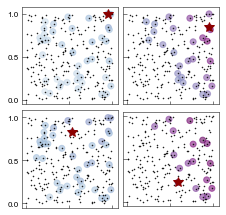

In [21]:
optimal_matrix, naive_matrix, optimal_cases = extract_optimal_cases(max_cases, max_msmt_var, 
                                                                    max_lambda_var=max_lambda_var_,
                                                                    metrictype=metrictype_)

gslayout = gs(3, 2 , top = 0.95, bottom =0.05, left = 0.1, right = 0.9, wspace = 0.05, hspace = 0.05)

pick_msmt_regimes = [1, 9]

fig = plt.figure(figsize=(cm2inch(8.7),cm2inch(12)))

for truth in range(len(weightratioslist)):
       
    for idx_opt in range(len(pick_msmt_regimes)):
    
        filename = weightratioslist[truth]
        a, index_array, naive = get_loss_data(filename, idx_prevar, pick_msmt_regimes[idx_opt])
        
        
        ax = fig.add_subplot(gslayout[truth, idx_opt ])
        ax.plot(lambda1[0:max_lambda_var_], lambda2[0:max_lambda_var_], 'ko', ms=0.5, alpha=1)
              
        optimal_color = 'darkred'
        diff = a[0] - a[index_array[0]]  
        if diff < 0 :
            optimal_color = 'g'
        elif diff >=0 :
            if diff < THRESHOLD: 
                optimal_color = 'g'



        better_than_control=[]
        for idx_l in index_array:
            diff = a[0] - a[idx_l] 

            if diff < 0 :
                break
            elif diff >=0 :
                if diff < THRESHOLD: 
                    break
            if idx_l == 0:
                break
            better_than_control.append(idx_l)
        
        red_values = np.take(a, better_than_control)
        im = ax.scatter(np.take(lambda1, better_than_control), 
                   np.take(lambda2, better_than_control),
                   c= red_values,
                   vmin=0.0, vmax=0.7, 
                   cmap='BuPu_r',alpha=0.6)
        
        ax.plot(lambda1[index_array[0]],lambda2[index_array[0]], '*',
                c=optimal_color, ms=10, alpha=1.)
        
        if idx_opt >0:
            ax.get_yaxis().set_ticklabels([])
        if truth < 2:
            ax.get_xaxis().set_ticklabels([])
        
        # Want square graphs with same number of ticks
        ax.set_aspect(1.)
        equaltics = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(equaltics)
        ax.yaxis.set_major_locator(equaltics)
        # ax.set(xlabel=r'$\lambda_i $', ylabel=r'$\lambda_j$')
        # ax.set_title(str(ParamUpdater.meta_max_iter_scan[pick_msmt_regimes[idx_opt]])+', '+str(np.round(a[index_array[0]] / a[0], 3)))
        
# plt.colorbar(im, ticks=[0.0, 0.7], format='%0.2f', orientation='horizontal')
plt.savefig('../paperfigs/opt_v3.svg', format='svg', dpi=800)
plt.show()

# Interpolation and Msmt Analysis 

In [22]:
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline

/home/riddhisw/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/riddhisw/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


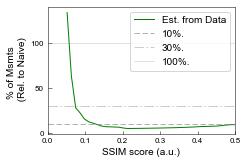

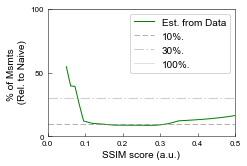

In [23]:
''' Save optimal_inverse_curves_list and use it in the next Workbook cell.
'''


algolabel = ['qslam', 'naive']
ssim_c = ['indigo', 'firebrick']
min_sims = [0.052, 0.05, 0.07]
maxssim = 0.5
start_iter=0


gslayout = gs(1, 1, top = 0.95, bottom =0.05, left = 0.12, right = 0.88, wspace = 0.4, hspace = 0.4)

optimal_inverse_curves_list = []
for idx_truth in range(max_cases):


    filename = weightratioslist[idx_truth]
    full_data_matrix = np.load(filename)["full_data_matrix"]    
    
    pickl = [optimal_cases[idx_truth, idx, 0] for idx in range(max_msmt_var)]
    qslam_data = [full_data_matrix[idx_prevar, idx, pickl[idx], 0, metrictype_] for idx in range(max_msmt_var)]
    naive_data = [full_data_matrix[idx_prevar, idx, pickl[idx], 1, metrictype_] for idx in range(max_msmt_var)]
    
    # Extrapolation range depends on the type of experiment
    ssim_vals = np.linspace(min_sims[idx_truth], maxssim, 40)
    
    # Interpolation 1D linear
    msmts = ParamUpdater.meta_max_iter_scan[start_iter:]
    qslam_invfunc = interp1d(qslam_data, msmts, fill_value='extrapolate')
    naive_invfunc = interp1d(naive_data, msmts, fill_value='extrapolate')

    ratio_extrapolated = qslam_invfunc(ssim_vals) / naive_invfunc(ssim_vals)

    ydata = [qslam_data, naive_data]
    interpy = {algolabel[0]: qslam_invfunc, algolabel[1]: naive_invfunc}
        
    # ---PLOT INVERSE FIGURE -----------------------------------------------------------------------------
    
    fig = plt.figure(figsize=(cm2inch(8.7),cm2inch(5)))

    ax = fig.add_subplot(gslayout[0,0])
    
    ax.plot(ssim_vals, ratio_extrapolated*100.0, '-', ms=1.5, lw=1.0, c='green', label="Est. from Data")
    ax.set_xlim([0.0, maxssim])
    ax.set_yticks(np.arange(0,1.25,0.5)*100.0)
    
    ax.axhline(y=10, ls='--', label='10%.', c='grey', alpha = 0.75, lw=0.8)
    ax.axhline(y=30, ls='-.', label='30%.', c='grey', alpha = 0.5, lw=0.8)
    ax.axhline(y=100, ls='-', label='100%.', c='grey', alpha = 0.3, lw=0.8)
 
    ax.set_xlabel('SSIM score (a.u.)')
    ax.set_ylabel('% of Msmts \n (Rel. to Naive)')
    ax.legend(loc=0)
    
    optimal_inverse_curves_list.append([ssim_vals, ratio_extrapolated])
        
    plt.savefig('../paperfigs/'+metrictypename+str(idx_truth)+'_opt_inv_v3.svg', format='svg', dpi=800)
    plt.show()

## FIXED LAMBDA

Truth:  0
Optimal lambda 0 for msmt iteration 3 20
0.887999807254
Optimal lambda 1 for msmt iteration 3 20
0.968852108212


/home/riddhisw/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/riddhisw/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


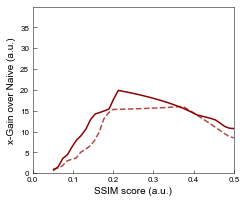

Truth:  1
Optimal lambda 0 for msmt iteration 3 20
0.785042692882
Optimal lambda 1 for msmt iteration 3 20
0.858034938437


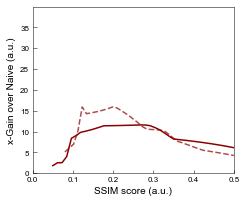

In [24]:
'''Add the fully optimised inverse curves '''


opt_lambda_at_iteration = 3
algolabel = ['qslam', 'naive']
ssim_c = ['indigo', 'firebrick']
min_sims = [0.05, 0.08, 0.068]
maxssim = 0.5
start_iter=0

gslayout = gs(1, 1, top = 0.99, bottom =0.15, left = 0.125, right = 0.95, wspace = 0.01, hspace = 0.01)

for idx_truth in range(max_cases):

    pick_lambda_idx = optimal_cases[idx_truth, opt_lambda_at_iteration, 0]
    
    print "Truth: ", idx_truth
    print "Optimal lambda 0 for msmt iteration", opt_lambda_at_iteration, ParamUpdater.meta_max_iter_scan[opt_lambda_at_iteration]
    print optimal_matrix[idx_truth, opt_lambda_at_iteration, 1]
    print "Optimal lambda 1 for msmt iteration", opt_lambda_at_iteration, ParamUpdater.meta_max_iter_scan[opt_lambda_at_iteration]
    print optimal_matrix[idx_truth, opt_lambda_at_iteration, 2]

    filename = weightratioslist[idx_truth]

    full_data_matrix = np.load(filename)["full_data_matrix"]    
    qslam_data = full_data_matrix[idx_prevar, start_iter:, pick_lambda_idx, 0, metrictype_] 
    naive_data = full_data_matrix[idx_prevar, start_iter:, pick_lambda_idx, 1, metrictype_]
    
    # Extrapolation range depends on the type of experiment
    ssim_vals = np.linspace(min_sims[idx_truth], maxssim, 40)
    
    # Interpolation 1D linear
    msmts = ParamUpdater.meta_max_iter_scan[start_iter:]
    qslam_invfunc = interp1d(qslam_data, msmts, fill_value='extrapolate')
    naive_invfunc = interp1d(naive_data, msmts, fill_value='extrapolate')

#     # Interpolation Univariate Spline
#     qidx = np.argsort(qslam_data)
#     nidx = np.argsort(naive_data)
#     msmts = ParamUpdater.meta_max_iter_scan[start_iter:]
#     qslam_invfunc = UnivariateSpline(np.take(qslam_data, qidx), np.take(msmts, qidx), k=1)#, fill_value='extrapolate')
#     naive_invfunc = UnivariateSpline(np.take(naive_data, nidx),  np.take(msmts, nidx), k=1)#, fill_value='extrapolate')

    ratio_extrapolated = qslam_invfunc(ssim_vals) / naive_invfunc(ssim_vals)

    ydata = [qslam_data, naive_data]
    interpy = {algolabel[0]: qslam_invfunc, algolabel[1]: naive_invfunc}


#     # -------CHECK INTERPOLATION BEFORE INVERTING IT ------------------------------------------
#     plt.figure()
#     ax = plt.subplot(111)
#     for algo in range(2):
#         ax.plot(interpy[algolabel[algo]](ssim_vals), ssim_vals, '--',  
#                 label = algolabel[algo],
#                 alpha = 1.0,
#                 color = ssim_c[algo],
#                 ms=1.5,
#                 lw=1.)

#     plt.show()
#     # ------------------------------------------------------------------------------------------
        
    # ---PLOT INVERSE FIGURE -----------------------------------------------------------------------------
    
    fig = plt.figure(figsize=(cm2inch(8.6),cm2inch(7)))
    ax = fig.add_subplot(gslayout[0,0])
    
    # ---- Add optimised curve here ---
    
    ax.plot(optimal_inverse_curves_list[idx_truth][0], 1./ optimal_inverse_curves_list[idx_truth][1],
           '-', ms=1.5, lw=1.5, alpha=1,c='darkred', label=r'$\lambda_{1,2}$ Optimal')
    
    # ---- Add a fixed lambda curve here ---
    ax.plot(ssim_vals, 1./ ratio_extrapolated, 
            '--', ms=1.5, lw=1.5, alpha=0.7, c='darkred', label=r'$\lambda_{1,3}$ at $%s$ iters' %(msmts[opt_lambda_at_iteration]))
    
    
    ax.set_xlim([0.0, maxssim])
    ax.set_yticks(np.arange(0, 36, 5))
    ax.set_ylim([0, 40])
 
    ax.set_xlabel('SSIM score (a.u.)')
    ax.set_ylabel('x-Gain over Naive (a.u.)')
#    ax.legend(loc=2, fontsize=8, frameon=False)
        
    plt.savefig('../paperfigs/'+metrictypename+str(idx_truth)+'_inv_v3.svg', format='svg', dpi=800)
    plt.show()

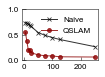

0
Optimal lambda 0
[ 0.50742239  0.88799981  0.97123103  0.88799981  0.98101952  0.872306
  0.92804888  0.97938074  0.84392175  0.89248456]
Optimal lambda 1
[ 0.76614525  0.96885211  0.94459776  0.96885211  0.99127996  0.91831488
  0.68006484  0.60611753  0.96390366  0.92697688]
Optimal lambda 0 at pick regime 1
0.887999807254
Optimal lambda 1 at pick_regime 1
0.968852108212
Optimal lambda 0 at pick regime 9
0.892484555997
Optimal lambda 1 at pick_regime 9
0.926976877469


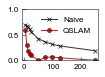

1
Optimal lambda 0
[ 0.13810754  0.78724444  0.92804888  0.78504269  0.717393    0.59022454
  0.81146779  0.83167473  0.76946254  0.59022454]
Optimal lambda 1
[ 0.65161562  0.80793083  0.68006484  0.85803494  0.84176217  0.23010274
  0.62820286  0.60725225  0.97163585  0.23010274]
Optimal lambda 0 at pick regime 1
0.787244437688
Optimal lambda 1 at pick_regime 1
0.807930829329
Optimal lambda 0 at pick regime 9
0.590224537958
Optimal lambda 1 at pick_regime 9
0.230102738121


In [25]:
optimal_matrix, naive_matrix, optimal_cases = extract_optimal_cases(max_cases, max_msmt_var, 
                                                                    max_lambda_var=max_lambda_var_,
                                                                    metrictype=metrictype_)

gslayout = gs(1,1 , top = 0.9, bottom =0.3, left = 0.3, right = 0.9, wspace = 0.01, hspace = 0.01)

pick_msmt_regimes = [1, 9]

for truth in range(len(weightratioslist)):
    
    fig = plt.figure(figsize=(cm2inch(4.5),cm2inch(3.)))
    
    ax1 = fig.add_subplot(gslayout[0, 0])
    
    ax1.plot(ParamUpdater.meta_max_iter_scan, naive_matrix[truth, :, 0], label='Naive',
            markerfacecolor='white', markeredgecolor='k', color='k', alpha=0.8,
            markeredgewidth=0.8, marker='x', linestyle='-', lw=1., ms=4)
    ax1.plot(ParamUpdater.meta_max_iter_scan, optimal_matrix[truth, :, 0], label='QSLAM',
            markerfacecolor='darkred', markeredgecolor='darkred', color='darkred', alpha=0.8,
            markeredgewidth=0.8, marker='o', linestyle='-', lw=1., ms=4)

#     #------------------------------------------------------
#     (mn, sn, bn) = ax1.stem(ParamUpdater.meta_max_iter_scan, naive_matrix[truth, :, 0], label='Naive')
#     ax1.fill_between(ParamUpdater.meta_max_iter_scan, naive_matrix[truth, :, 0], 
#                      color='k', alpha=0.15)
#     plt.setp(bn, visible=False) # baseline
#     plt.setp(mn, marker='+', color='k', ms=5, alpha=0.8) # markers
#     plt.setp(sn, color='w', alpha=.5) # stems

#     #------------------------------------------------------
#     (m, s, b) = ax1.stem(ParamUpdater.meta_max_iter_scan, optimal_matrix[truth, :, 0], label='QSLAM')

#     ax1.fill_between(ParamUpdater.meta_max_iter_scan, optimal_matrix[truth, :, 0], 
#                      color='darkred', alpha=0.5)
    
#     plt.setp(b, visible=False) # baseline
#     plt.setp(m, marker='x', color='darkred', ms=5, alpha=0.8) # markers
#     plt.setp(s, color='w', alpha=.2) # stems

#     ax1.set(ylabel='SSIM (a.u.)', xlabel=' Msmts (num)')
#     
#     #plt.legend(loc=4)
#     #----------------------------------------------------------------------------------------------------
#     ax2 = ax1.twinx()
#     ax2.plot(ParamUpdater.meta_max_iter_scan, optimal_matrix[truth, :, 1], 
#              'o-', c='g', ms=4, label=r'$\lambda_1$', alpha=0.5)
#     ax2.plot(ParamUpdater.meta_max_iter_scan, optimal_matrix[truth, :, 2],
#              'o-', c='slateblue', ms=4, label=r'$\lambda_2$', alpha=0.5)
#     ax2.set_ylim([0, 1])
#     ax2.set(ylabel=r'Optimal $\lambda_i, i=1,2$')
    ax1.set_ylim([0, 1])
    plt.legend(loc=0, fontsize=8, frameon=False)
    
    #----------------------------------------------------------------------------------------------------
    plt.savefig('../paperfigs/'+metrictypename+str(truth)+'_inset_v3.svg', format='svg', dpi=800)
    plt.show()
    
    
    print truth
    print "Optimal lambda 0"
    print optimal_matrix[truth, :, 1]
    print "Optimal lambda 1"
    print optimal_matrix[truth, :, 2]
    
    for pick_regime in pick_msmt_regimes:
        
        print "Optimal lambda 0 at pick regime", pick_regime
        print optimal_matrix[truth, pick_regime, 1]
        print "Optimal lambda 1 at pick_regime", pick_regime
        print optimal_matrix[truth, pick_regime, 2]